In [1]:
import collections

import supermarq
import cirq
import matplotlib.pyplot as plt

# Introduction

In [2]:
def noisy_simulation(circuit: cirq.Circuit, p: float) -> collections.Counter:
    """
    Simulate the given circuit under a depolarizing noise model where every
    gate operation has the chance of depolarizing the qubit with probability p.
    """
    
    shots = 1000
    result = cirq.Simulator().run(circuit.with_noise(cirq.depolarize(p=p)),
                                  repetitions=shots)

    num_measured_qubits = []
    for _, op in circuit.findall_operations(cirq.is_measurement):
        num_measured_qubits.append(len(op.qubits))
    raw_counts = result.multi_measurement_histogram(keys=result.measurements.keys())

    # cirq.Result.multi_measurement_histogram returns a collection.Counter object
    # where the keys are tuples of integers and the values are the shot counts.
    # The integers in the keys indicate the bitstring result of each set of measurement tags.
    counts: Dict[str, float] = collections.defaultdict(float)
    for key, val in raw_counts.items():
        bit_list = []
        for int_tag, num_bits in zip(key, num_measured_qubits):
            bit_list.extend(cirq.value.big_endian_int_to_bits(int_tag, bit_count=num_bits))
        counts["".join([str(b) for b in bit_list])] = val / shots

    return collections.Counter(counts)

# Benchmarks

## GHZ

In [13]:
supermarq.ghz.GHZ?

Init signature: supermarq.ghz.GHZ(n: int) -> None
Docstring:     
Represents the GHZ state preparation benchmark parameterized
by the number of qubits n.

Device performance is based on the Hellinger fidelity between
the experimental and ideal probability distributions.
File:           ~/Workspace/SuperTech/SupermarQ_HPCA_Artifact/supermarq/benchmarks/ghz.py
Type:           type
Subclasses:     


In [14]:
# Create the benchmark object and circuit
num_qubits = 5
ghz = supermarq.ghz.GHZ(num_qubits)
ghz_circuit = ghz.circuit()
print(ghz_circuit)

0: ───H───@───────────────M───
          │               │
1: ───────X───@───────────M───
              │           │
2: ───────────X───@───────M───
                  │       │
3: ───────────────X───@───M───
                      │   │
4: ───────────────────X───M───


In [17]:
# Perform noisy simulation and evaluate the benchmark score function
ghz_scores = []
for error_prob in [0.0, 0.005, 0.02]:
    counts = noisy_simulation(ghz_circuit, p=error_prob)
    score = ghz.score(counts)
    ghz_scores.append((error_prob, score))
    print(f'With {error_prob*100:.1f}% error probability, GHZ score = {score:.4f}')

With 0.0% error probability, GHZ score = 0.9999
With 0.5% error probability, GHZ score = 0.9260
With 2.0% error probability, GHZ score = 0.7295


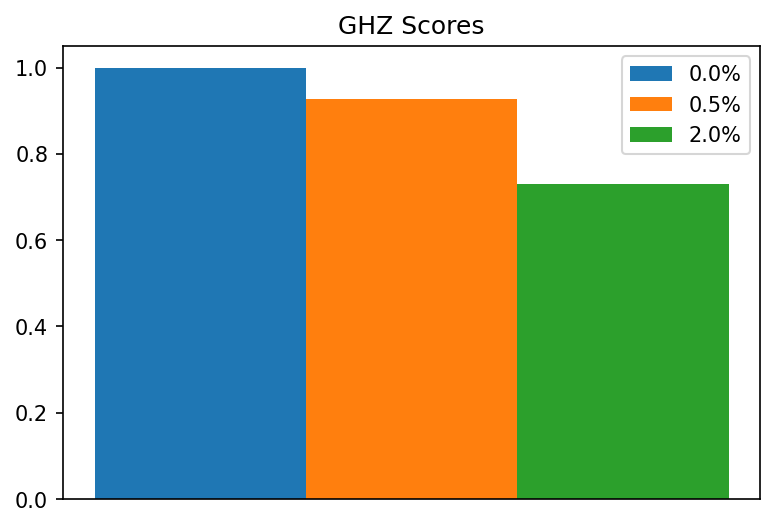

In [18]:
# Plot the results
fig, ax = plt.subplots(dpi=150)
width = 0.1

for i, (error_prob, score) in enumerate(ghz_scores):
    x = width * i
    ax.bar(x, score, width=width, label=f'{error_prob * 100:.1f}%', align='edge')

ax.legend()
ax.set_title('GHZ Scores')
ax.get_xaxis().set_visible(False)

## Mermin-Bell

In [23]:
supermarq.mermin_bell.MerminBell?

Init signature: supermarq.mermin_bell.MerminBell(num_qubits: int) -> None
Docstring:     
The Mermin-Bell benchmark is a test of a quantum computer's ability
to exploit purely quantum phenomemna such as superposition and entanglement.
It is based on the famous Bell-inequality tests of locality.

Performance is based on a QPU's ability to prepare a GHZ state and measure
the Mermin operator.
File:           ~/Workspace/SuperTech/SupermarQ_HPCA_Artifact/supermarq/benchmarks/mermin_bell.py
Type:           type
Subclasses:     


In [19]:
# Create the benchmark object and circuit
num_qubits = 3
merminbell = supermarq.mermin_bell.MerminBell(num_qubits)
mb_circuit = merminbell.circuit()
print(mb_circuit)

0: ───Rx(-0.5π)───@───────────@───────X───X───S───@───H───────M───
                  │           │       │   │       │           │
1: ───────────────X───@───H───┼───@───┼───@───────@───S───H───M───
                      │       │   │   │                       │
2: ───────────────────X───H───X───X───@───S───H───────────────M───


In [20]:
# Perform noisy simulation and evaluate the benchmark score function
merminbell_scores = []
for error_prob in [0.0, 0.005, 0.02]:
    counts = noisy_simulation(mb_circuit, p=error_prob)
    score = merminbell.score(counts)
    merminbell_scores.append((error_prob, score))
    print(f'With {error_prob*100:.1f}% error probability, MerminBell score = {score:.4f}')

<mermin_op> = 4.0
With 0.0% error probability, MerminBell score = 1.0000
<mermin_op> = 3.34
With 0.5% error probability, MerminBell score = 0.9175
<mermin_op> = 2.02
With 2.0% error probability, MerminBell score = 0.7525


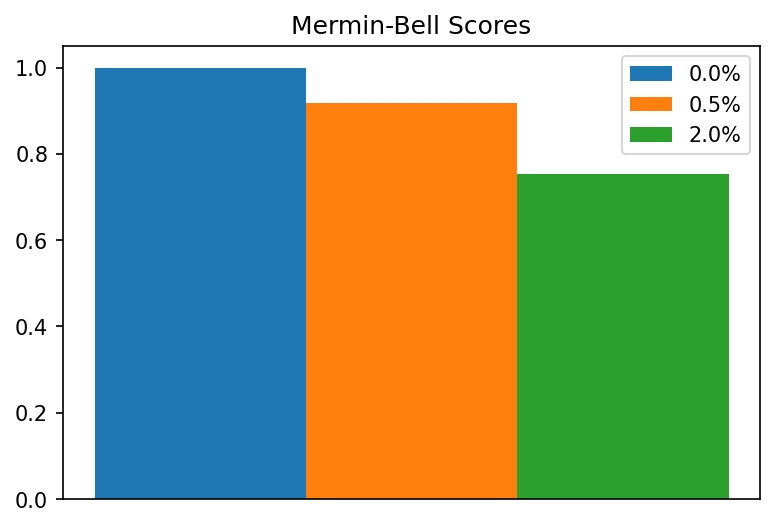

In [21]:
# Plot the results
fig, ax = plt.subplots(dpi=150)
width = 0.1

for i, (error_prob, score) in enumerate(merminbell_scores):
    
    x = width * i
    ax.bar(x, score, width=width, label=f'{error_prob * 100:.1f}%', align='edge')

ax.legend()
ax.set_title('Mermin-Bell Scores')
ax.get_xaxis().set_visible(False)

## Bit Code

In [24]:
supermarq.bit_code.BitCode?

Init signature:
supermarq.bit_code.BitCode(
    num_data_qubits: int,
    num_rounds: int,
    bit_state: List[int] = [0, 1, 0],
) -> None
Docstring:     
Creates a circuit for syndrome measurement in a bit-flip error correcting code.

Args:
- num_data: The number of data qubits
- num_rounds: The number of measurement rounds
- bit_state: A list denoting the state to initialize each data qubit to.

returns a cirq circuit for the bit-flip error correcting code
File:           ~/Workspace/SuperTech/SupermarQ_HPCA_Artifact/supermarq/benchmarks/bit_code.py
Type:           type
Subclasses:     


In [22]:
# Create the benchmark object and circuit
num_data_qubits = 3
num_rounds = 2
bit_state = [0, 1, 0]
bitcode = supermarq.bit_code.BitCode(num_data_qubits, num_rounds, bit_state)
bitcode_circuit = bitcode.circuit()
print(bitcode_circuit)

0: ───@─────────────────────────@─────────────────────────────────────────────────────M───
      │                         │                                                     │
1: ───X───X───M('mcm1_0')───R───X─────────────X───M('mcm1_1')───R─────────────────────M───
          │                                   │                                       │
2: ───X───@───@───────────────────────────────@───@───────────────────────────────────M───
              │                                   │                                   │
3: ───────────X─────────────X───M('mcm3_0')───R───X─────────────X───M('mcm3_1')───R───M───
                            │                                   │                     │
4: ─────────────────────────@───────────────────────────────────@─────────────────────M───


In [5]:
# Perform noisy simulation and evaluate the benchmark score function
bitcode_scores = []
for error_prob in [0.0, 0.005, 0.02]:
    counts = noisy_simulation(bitcode_circuit, p=error_prob)
    score = bitcode.score(counts)
    bitcode_scores.append((error_prob, score))
    print(f'With {error_prob*100:.1f}% error probability, BitCode score = {score:.4f}')

With 0.0% error probability, BitCode score = 1.0
With 0.5% error probability, BitCode score = 0.8719999999999999
With 2.0% error probability, BitCode score = 0.5549999999999998


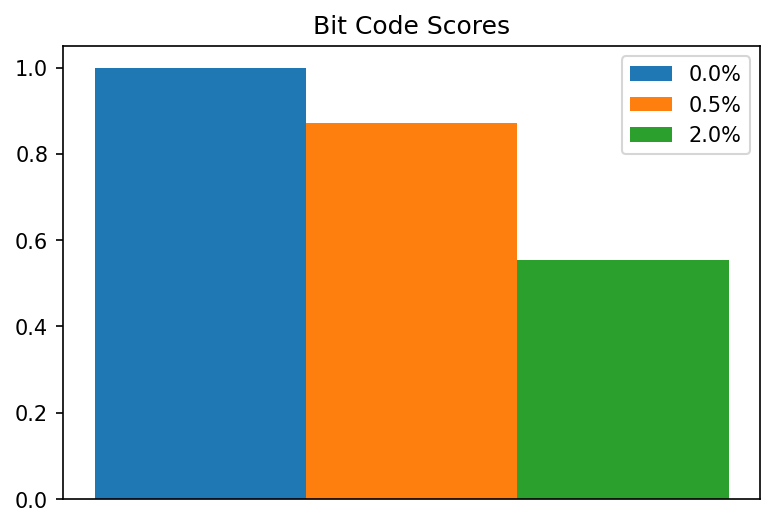

In [6]:
# Plot the results
fig, ax = plt.subplots(dpi=150)
width = 0.1

for i, (error_prob, score) in enumerate(bitcode_scores):
    
    x = width * i
    ax.bar(x, score, width=width, label=f'{error_prob * 100:.1f}%', align='edge')

ax.legend()
ax.set_title('Bit Code Scores')
ax.get_xaxis().set_visible(False)

## Phase Code

In [25]:
supermarq.phase_code.PhaseCode?

Init signature:
supermarq.phase_code.PhaseCode(
    num_data_qubits: int,
    num_rounds: int,
    phase_state: List[int] = [0, 1, 0],
) -> None
Docstring:     
Creates a circuit for syndrome measurement in a phase-flip error
correcting code.

Args:
- num_data: The number of data qubits
- num_rounds: The number of measurement rounds
- phase_state: A list denoting the state to initialize each data
               qubit to. Currently just + or - states. 0 -> +, 1 -> -

returns a cirq circuit for the phase-flip error correcting code
File:           ~/Workspace/SuperTech/SupermarQ_HPCA_Artifact/supermarq/benchmarks/phase_code.py
Type:           type
Subclasses:     


In [3]:
# Create the benchmark object and circuit
num_data_qubits = 3
num_rounds = 2
phase_state = [0, 1, 0]
phasecode = supermarq.phase_code.PhaseCode(num_data_qubits, num_rounds, phase_state)
phasecode_circuit = phasecode.circuit()
print(phasecode_circuit)

0: ───H───H───@───H───H───────────────────────────────────@───H───────────────────────────────────────────M───
              │                                           │                                               │
1: ───H───────@───@───H───M('mcm1_0')───R───H─────────────@───@───H───M('mcm1_1')───R─────────────────────M───
                  │                                           │                                           │
2: ───X───H───H───@───@───H─────────────H─────────────────────@───@───H───────────────────────────────────M───
                      │                                           │                                       │
3: ───H───────────────@───@─────────────H───M('mcm3_0')───R───H───@───@─────────────H───M('mcm3_1')───R───M───
                          │                                           │                                   │
4: ───H───H───────────────@─────────────H───H─────────────────────────@─────────────H─────────────────────M───


In [4]:
# Perform noisy simulation and evaluate the benchmark score function
phasecode_scores = []
for error_prob in [0.0, 0.005, 0.02]:
    counts = noisy_simulation(phasecode_circuit, p=error_prob)
    score = phasecode.score(counts)
    phasecode_scores.append((error_prob, score))
    print(f'With {error_prob*100:.1f}% error probability, PhaseCode score = {score:.4f}')

With 0.0% error probability, PhaseCode score = 0.9976
With 0.5% error probability, PhaseCode score = 0.8251
With 2.0% error probability, PhaseCode score = 0.4795


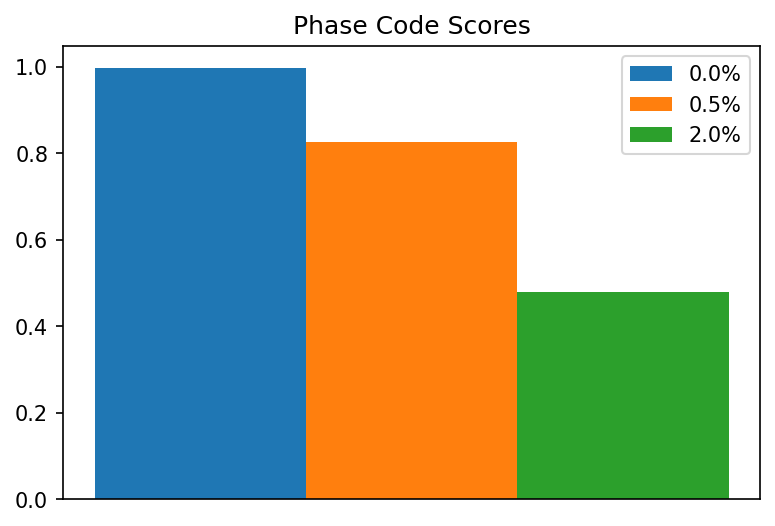

In [5]:
# Plot the results
fig, ax = plt.subplots(dpi=150)
width = 0.1

for i, (error_prob, score) in enumerate(phasecode_scores):
    
    x = width * i
    ax.bar(x, score, width=width, label=f'{error_prob * 100:.1f}%', align='edge')

ax.legend()
ax.set_title('Phase Code Scores')
ax.get_xaxis().set_visible(False)

## VQE

In [8]:
supermarq.vqe_proxy.VQEProxy?

Init signature: supermarq.vqe_proxy.VQEProxy(num_qubits: int, num_layers: int = 1) -> None
Docstring:     
Proxy benchmark of a full VQE application that targets a single iteration
of the whole variational optimization.

The benchmark is parameterized by the number of qubits, n. For each value of
n, we classically optimize the ansatz, sample 3 iterations near convergence,
and use the sampled parameters to execute the corresponding circuits on the
QPU. We take the measured energies from these experiments and average their
values and compute a score based on how closely the experimental results are
to the noiseless values.
File:           ~/Workspace/SuperTech/SupermarQ_HPCA_Artifact/supermarq/benchmarks/vqe_proxy.py
Type:           type
Subclasses:     


In [10]:
# Create the benchmark object and circuit
num_qubits = 3
num_layers = 2
vqe = supermarq.vqe_proxy.VQEProxy(num_qubits, num_layers)
vqe_circuit = vqe.circuit()
print('Z basis circuit:')
print(vqe_circuit[0])
print('\nX basis circuit:')
print(vqe_circuit[1])

Z basis circuit
0: ───Ry(0.31π)────Rz(0.178π)───@───Ry(-1.54π)───Rz(-1.86π)───Ry(-0.139π)───Rz(-0.679π)────────────────@───Ry(-1.4π)───Rz(-1.87π)─────────────────M───
                                │                                                                      │                                          │
1: ───Ry(1.21π)────Rz(1.8π)─────X───@────────────Ry(0.923π)───Rz(-0.544π)───Ry(-1.7π)─────Rz(0.264π)───X───@───────────Ry(0.916π)───Rz(0.471π)────M───
                                    │                                                                      │                                      │
2: ───Ry(0.124π)───Rz(0.03π)────────X────────────Ry(1.14π)────Rz(1.94π)─────Ry(0.143π)────Rz(0.792π)───────X───────────Ry(0.771π)───Rz(-0.403π)───M───
X basis circuit
0: ───Ry(0.31π)────Rz(0.178π)───@───Ry(-1.54π)───Rz(-1.86π)───Ry(-0.139π)───Rz(-0.679π)────────────────@───Ry(-1.4π)───Rz(-1.87π)───H─────────────────M───
                                │                               

In [11]:
# Perform noisy simulation and evaluate the benchmark score function
vqe_scores = []
for error_prob in [0.0, 0.005, 0.02]:
    z_counts = noisy_simulation(vqe_circuit[0], p=error_prob)
    x_counts = noisy_simulation(vqe_circuit[1], p=error_prob)
    score = vqe.score([z_counts, x_counts])
    vqe_scores.append((error_prob, score))
    print(f'With {error_prob*100:.1f}% error probability, VQE score = {score:.4f}')

With 0.0% error probability, VQE score = 0.9975
With 0.5% error probability, VQE score = 0.9327
With 2.0% error probability, VQE score = 0.7551


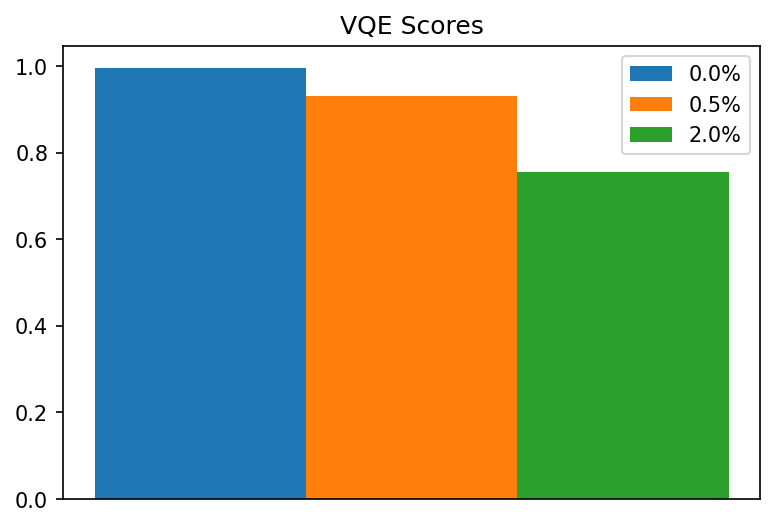

In [12]:
# Plot the results
fig, ax = plt.subplots(dpi=150)
width = 0.1

for i, (error_prob, score) in enumerate(vqe_scores):
    
    x = width * i
    ax.bar(x, score, width=width, label=f'{error_prob * 100:.1f}%', align='edge')

ax.legend()
ax.set_title('VQE Scores')
ax.get_xaxis().set_visible(False)

## Hamiltonian Simulation

In [26]:
supermarq.hamiltonian_simulation.HamiltonianSimulation?

Init signature:
supermarq.hamiltonian_simulation.HamiltonianSimulation(
    num_qubits: int,
    time_step: int,
    total_time: int,
) -> None
Docstring:     
Quantum benchmark focused on the ability to simulate 1D
Transverse Field Ising Models (TFIM) of variable length.

Device performance is based on how closely the experimentally obtained
average magnetization (along the Z-axis) matches the noiseless value.
Since the 1D TFIM is efficiently simulatable with classical algorithms,
computing the noiseless average magnetization remains scalable over a large
range of benchmark sizes.
Init docstring:
Args:
num_qubits: int
    Size of the TFIM chain, equivalent to the number of qubits.
time_step: int
    Size of the timestep in attoseconds.
total_time:
    Total simulation time of the TFIM chain in attoseconds.
File:           ~/Workspace/SuperTech/SupermarQ_HPCA_Artifact/supermarq/benchmarks/hamiltonian_simulation.py
Type:           type
Subclasses:     


In [27]:
# Create the benchmark object and circuit
num_qubits = 3
time_step = 1
total_time = 2
hamsim = supermarq.hamiltonian_simulation.HamiltonianSimulation(num_qubits, time_step, total_time)
hamsim_circuit = hamsim.circuit()
print(hamsim_circuit)

0: ───H───Rz(-0.75π)───H───@───────────────@───H───Rz(-0.749π)───H─────────────────────────@───────────────@───────────────────────M───
                           │               │                                               │               │                       │
1: ───H───Rz(-0.75π)───H───X───Rz(-0.5π)───X───@─────────────────@───H───Rz(-0.749π)───H───X───Rz(-0.5π)───X───@───────────────@───M───
                                               │                 │                                             │               │   │
2: ───H───Rz(-0.75π)───H───────────────────────X───Rz(-0.5π)─────X───H───Rz(-0.749π)───H───────────────────────X───Rz(-0.5π)───X───M───


In [28]:
# Perform noisy simulation and evaluate the benchmark score function
hamsim_scores = []
for error_prob in [0.0, 0.005, 0.02]:
    counts = noisy_simulation(hamsim_circuit, p=error_prob)
    score = hamsim.score(counts)
    hamsim_scores.append((error_prob, score))
    print(f'With {error_prob*100:.1f}% error probability, Hamiltonian Simulation score = {score:.4f}')

With 0.0% error probability, Hamiltonian Simulation score = 0.9806
With 0.5% error probability, Hamiltonian Simulation score = 0.9501
With 2.0% error probability, Hamiltonian Simulation score = 0.8618


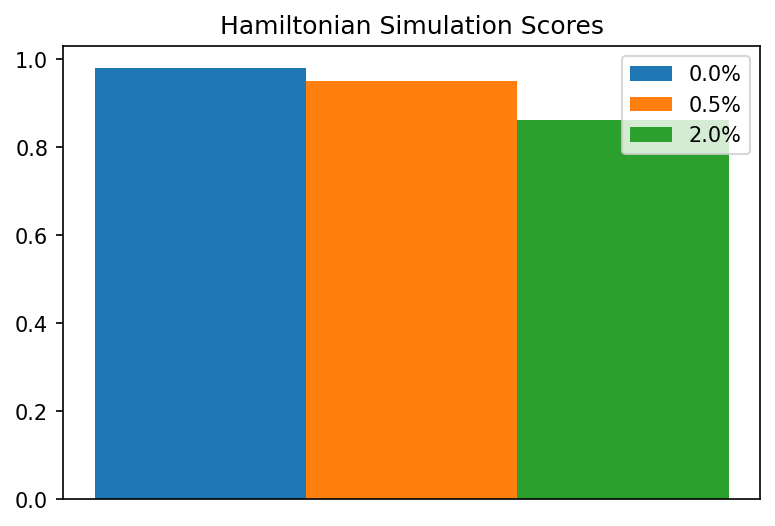

In [29]:
# Plot the results
fig, ax = plt.subplots(dpi=150)
width = 0.1

for i, (error_prob, score) in enumerate(hamsim_scores):
    
    x = width * i
    ax.bar(x, score, width=width, label=f'{error_prob * 100:.1f}%', align='edge')

ax.legend()
ax.set_title('Hamiltonian Simulation Scores')
ax.get_xaxis().set_visible(False)

## Fermionic-SWAP QAOA

In [30]:
supermarq.qaoa_fermionic_swap_proxy.QAOAFermionicSwapProxy?

Init signature: supermarq.qaoa_fermionic_swap_proxy.QAOAFermionicSwapProxy(num_qubits: int) -> None
Docstring:     
Proxy of a full Quantum Approximate Optimization Algorithm
(QAOA) benchmark. The benchmark targets MaxCut on a Sherrington-Kirkpatrick model.

Device performance is given by the Hellinger fidelity between the experimental
output distribution and the true distribution obtained via scalable, classical
simulation.
File:           ~/Workspace/SuperTech/SupermarQ_HPCA_Artifact/supermarq/benchmarks/qaoa_fermionic_swap_proxy.py
Type:           type
Subclasses:     


In [31]:
# Create the benchmark object and circuit
num_qubits = 3
fermionic_qaoa = supermarq.qaoa_fermionic_swap_proxy.QAOAFermionicSwapProxy(num_qubits)
fqaoa_circuit = fermionic_qaoa.circuit()
print(fqaoa_circuit)

0: ───H───@───────────────X───@───────────────────────────@────────────────────────X───@───Rx(0.196π)───M───
          │               │   │                           │                        │   │                │
1: ───H───X───Rz(-1.2π)───@───X───@───────────────X───@───X────────────Rz(-1.2π)───@───X───Rx(0.196π)───M───
                                  │               │   │                                                 │
2: ───H───────────────────────────X───Rz(-1.2π)───@───X───Rx(0.196π)────────────────────────────────────M───


In [32]:
# Perform noisy simulation and evaluate the benchmark score function
fqaoa_scores = []
for error_prob in [0.0, 0.005, 0.02]:
    counts = noisy_simulation(fqaoa_circuit, p=error_prob)
    score = fermionic_qaoa.score(counts)
    fqaoa_scores.append((error_prob, score))
    print(f'With {error_prob*100:.1f}% error probability, Fermionic SWAP QAOA score = {score:.4f}')

With 0.0% error probability, Fermionic QAOA score = 1.0000
With 0.5% error probability, Fermionic QAOA score = 0.9400
With 2.0% error probability, Fermionic QAOA score = 0.7640


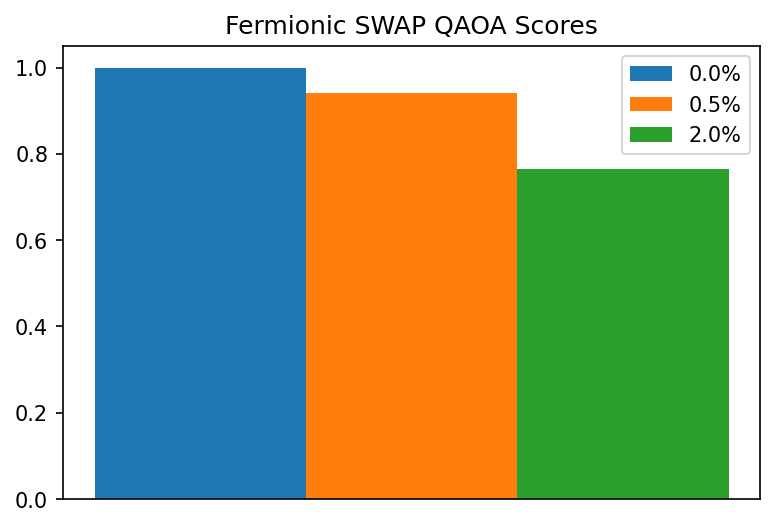

In [33]:
# Plot the results
fig, ax = plt.subplots(dpi=150)
width = 0.1

for i, (error_prob, score) in enumerate(fqaoa_scores):
    
    x = width * i
    ax.bar(x, score, width=width, label=f'{error_prob * 100:.1f}%', align='edge')

ax.legend()
ax.set_title('Fermionic SWAP QAOA Scores')
ax.get_xaxis().set_visible(False)

## Vanilla QAOA

In [34]:
supermarq.qaoa_vanilla_proxy.QAOAVanillaProxy?

Init signature: supermarq.qaoa_vanilla_proxy.QAOAVanillaProxy(num_qubits: int) -> None
Docstring:     
Proxy of a full Quantum Approximate Optimization Algorithm
(QAOA) benchmark. The benchmark targets MaxCut on a Sherrington-Kirkpatrick model.
Device performance is given by the Hellinger fidelity between the experimental
output distribution and the true distribution obtained via scalable, classical
simulation.
File:           ~/Workspace/SuperTech/SupermarQ_HPCA_Artifact/supermarq/benchmarks/qaoa_vanilla_proxy.py
Type:           type
Subclasses:     


In [35]:
# Create the benchmark object and circuit
num_qubits = 3
vanilla_qaoa = supermarq.qaoa_vanilla_proxy.QAOAVanillaProxy(num_qubits)
vqaoa_circuit = vanilla_qaoa.circuit()
print(vqaoa_circuit)

                                                      ┌───────────┐
0: ───H─────────────────────────@─────────────────@────@───────────────────────────@───Rx(0.637π)───M───
                                │                 │    │                           │                │
1: ───H───@─────────────────@───X───Rz(-0.637π)───X────┼Rx(0.637π)─────────────────┼────────────────M───
          │                 │                          │                           │                │
2: ───H───X───Rz(-0.637π)───X──────────────────────────X──────────────Rz(0.637π)───X───Rx(0.637π)───M───
                                                      └───────────┘


In [ ]:
# Perform noisy simulation and evaluate the benchmark score function
vqaoa_scores = []
for error_prob in [0.0, 0.005, 0.02]:
    counts = noisy_simulation(vqaoa_circuit, p=error_prob)
    score = vanilla_qaoa.score(counts)
    vqaoa_scores.append((error_prob, score))
    print(f'With {error_prob*100:.1f}% error probability, Vanilla QAOA score = {score:.4f}')

In [ ]:
# Plot the results
fig, ax = plt.subplots(dpi=150)
width = 0.1

for i, (error_prob, score) in enumerate(vqaoa_scores):
    
    x = width * i
    ax.bar(x, score, width=width, label=f'{error_prob * 100:.1f}%', align='edge')

ax.legend()
ax.set_title('Vanilla QAOA Scores')
ax.get_xaxis().set_visible(False)